In [1]:
%matplotlib inline
import pprint as pp

import matplotlib.pyplot as plt
import networkx as nx
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil2 as teo

plt.style.use("ggplot")

# TEOTIL2 tutorial 02: Total nitrogen and phosphorus

This notebook illustrates usage of TEOTIL2 - a Python implementation of [TEOTIL](https://niva.brage.unit.no/niva-xmlui/handle/11250/214825) - for simulating fluxes of nitrogen (N) and phosphorus (P) to the Norwegian coastline.

**Note:** If you wish to build the model input file from scratch (Section 1), all key datasets - discharge, point sources, agricultural land use coefficients etc. - for the year of interest must first be pre-processed and added to NIVA's RESA2 database (see e.g. [here](https://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/process_model_inputs_2018.ipynb) for details). This notebook must then be run with a direct connection to the Nivabase. Alternatively, you can skip Section 1 and use the pre-built input files from `./data/norway_annual_input_data` (see Section 2).

#### Disclaimer

As far as possible, the Python implementation of TEOTIL2 uses the same datasets and equations derived for the original TEOTIL model. Some minor improvements to the calculations have been made, but the main changes are in *how* the calculations are performed, not in the calculations themselves (e.g. TEOTIL2 is *much* fatser than TEOTIL1). Some inconsistencies in the original method should be improved and many of the "core" input datasets could also be updated. This work has not yet been done, partly due to lack of time/funding, but also to maintain compatibility with previous model results.

In [2]:
# Year of interest
year = 2015

# Parameters of interest
par_list = ["Tot-N", "Tot-P"]

# Folder containing TEOTIL2 data
data_fold = r"../data/core_input_data"

## 1. Generate an input file

Tutorial 01 demonstrated the basic principles of TEOTIL2, which are fairly straightforward once a suitable input file has been created. The original TEOTIL model has been model widely used in Norway for simulating nutrient fluxes (nitrogen and phosphorus) at national scale, for example as part of Miljødirektoratet's [Elveovervåkingsprogrammet](https://github.com/JamesSample/rid) and for reporting to the [OSPAR Commission](https://www.ospar.org/). 

Each year, NIVA collates relevant datasets and stores them in a database. For those with access to NIVA's internal network, TEOTIL2 provides a convenient function for generating input files with the correct format: first connect to the database, then specify the parameters of interest (`nutrients` or `metals`) and the paths to relevant datasets. Finally, run `make_input_file` to gnerate the file. As you can see in the examples [here](https://github.com/NIVANorge/teotil2/tree/main/data/norway_annual_input_data), these files have exactly the same basic structure as the "toy" dataset from Tutorial 01, although these files are must more complicated.

**Note:** If you don't have access to NIVA's database, skip this step and use one of the pre-built input files in this repository.

In [3]:
# # Connect to db
# eng = nivapy.da.connect()

In [4]:
# # Make input file
# ann_csv = f"../data/norway_annual_input_data/input_data_{year}.csv"
# df = teo.make_input_file(year, eng, data_fold, ann_csv, mode='nutrients', par_list=par_list)

## 2. Run model

To run the model, **either** pass the path to the CSV created above or provide the returned dataframe directly, then call `run_model()`. In the code below, `%%time` is used to measure the total runtime (reading the inputs and performing the network accumulation). Passing the dataframe directly is marginally faster, but requires creating the input file each time from the RESA2 database (which requires a database connection).

In [5]:
%%time
# Run model
ann_csv = f"../data/norway_annual_input_data/input_data_{year}.csv"
g = teo.run_model(ann_csv)

CPU times: user 7.82 s, sys: 110 ms, total: 7.93 s
Wall time: 7.99 s


On this laptop, the new model takes around 8 seconds to process the data for N and P. Note that running the original TEOTIL on the same machine takes approximately 8 hours, so the new model is substantially faster (by a factor of about 3600).

## 3. Explore output

This section is very similar to Section 3 of Tutorial 01, but now the model output is more comprehensive and based on real data.

### 3.1. Basic data access

The model returns a "network object", where each node in the network corresponds to a catchment. Each node has two data stores associated with it: one containing the `local` inputs from each specific regine catchment, and a second called `accum` which stores accumulated results (i.e. including upstream inputs and allowing for retention). These properties can be queried as follows:

In [6]:
# Catchment ID of interest
reg_id = "001.1A40"

# Get local data for catchment
print(f"Local data for '{reg_id}':")
pp.pprint(g.nodes[reg_id]["local"])
print("")

# Get accum data for catchment
print(f"Accumulated data for '{reg_id}':")
pp.pprint(g.nodes[reg_id]["accum"])

Local data for '001.1A40':
{'a_reg_km2': 12.37,
 'agri_diff_tot-n_tonnes': 3.5701360038325523,
 'agri_diff_tot-p_tonnes': 0.2234827326934844,
 'agri_pt_tot-n_tonnes': 0.04342069265287831,
 'agri_pt_tot-p_tonnes': 0.0035099000777212733,
 'all_point_tot-n_tonnes': 0.4685274321110722,
 'all_point_tot-p_tonnes': 0.03543877277933409,
 'all_sources_tot-n_tonnes': 7.2362358571236625,
 'all_sources_tot-p_tonnes': 0.3073312050376743,
 'anth_diff_tot-n_tonnes': 3.5701360038325523,
 'anth_diff_tot-p_tonnes': 0.2234827326934844,
 'aqu_tot-n_tonnes': 0.0,
 'aqu_tot-p_tonnes': 0.0,
 'ind_tot-n_tonnes': 0.0,
 'ind_tot-p_tonnes': 0.0,
 'nat_diff_tot-n_tonnes': 3.1975724211800385,
 'nat_diff_tot-p_tonnes': 0.04840969956485587,
 'q_reg_m3/s': 0.17193583835514212,
 'regine': '001.1A40',
 'regine_ned': '001.1A3',
 'ren_tot-n_tonnes': 0.0,
 'ren_tot-p_tonnes': 0.0,
 'runoff_mm/yr': 438.3321421477576,
 'spr_tot-n_tonnes': 0.4251067394581939,
 'spr_tot-p_tonnes': 0.03192887270161282,
 'trans_tot-n': 1.0,
 't

### 3.2. Network diagrams

The model can create schematic diagrams upstream and downstream from any node. These can be annotated with any output value the user chooses.

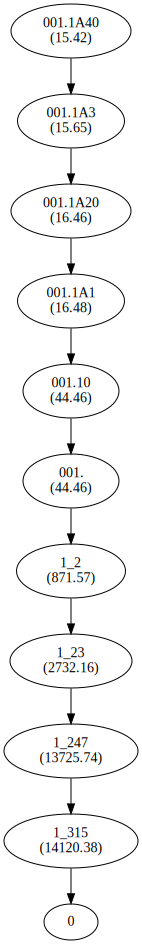

In [7]:
# Plot network labelled with accumulated flow
teo.plot_network(g, "001.1A40", direct="down", stat="accum", quant="q_m3/s")

### 3.3. Summary maps

The user can also choose `local` or `accum` and specify a parameter of interest to generate a simple map. Note that this takes about 20 seconds, as rendering the regine polygons is computationally intensive. Optionally, the data can be log or square-root transformed before plotting, and different colour schemes can be applied. The plot can also be saved as an image file by specifying the `plot_path`.

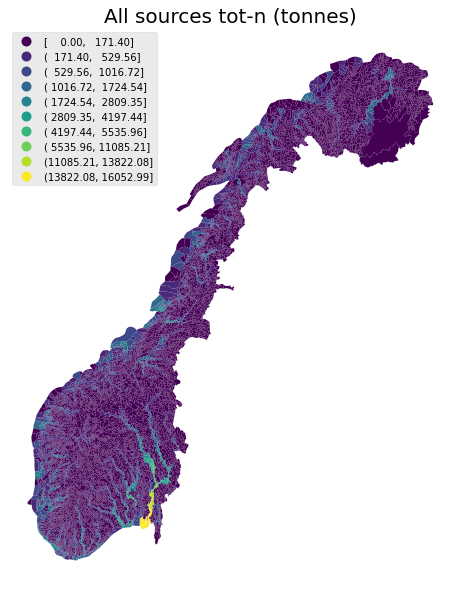

In [8]:
# Summary map of local runoff
teo.make_map(
    g,
    stat="accum",
    quant="all_sources_tot-n_tonnes",
    trans="none",
    cmap="viridis",
    scheme='natural_breaks',
    n_classes=10,
#    plot_path=f"../plots/nutrients/accum_all_sources_tot-n_{year}.png",
)

### 3.4. Write results to CSV

The graph can be converted to CSV format for further analysis.

In [9]:
# Save results as csv
out_csv = f"../data/norway_annual_output_data/teotil2_results_{year}.csv"
df = teo.model_to_dataframe(g, out_path=out_csv)

df.head()

,regine,regine_ned,accum_agri_diff_tot-n_tonnes,accum_agri_diff_tot-p_tonnes,accum_agri_pt_tot-n_tonnes,accum_agri_pt_tot-p_tonnes,accum_all_point_tot-n_tonnes,accum_all_point_tot-p_tonnes,accum_all_sources_tot-n_tonnes,accum_all_sources_tot-p_tonnes,...,local_ren_tot-n_tonnes,local_ren_tot-p_tonnes,local_runoff_mm/yr,local_spr_tot-n_tonnes,local_spr_tot-p_tonnes,local_trans_tot-n,local_trans_tot-p,local_urban_tot-n_tonnes,local_urban_tot-p_tonnes,local_vol_lake_m3
0,315.0,315.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.422426,0.010087,...,0.0000,0.0000,127.393959,0.000000,0.000000,1.00,1.00,0.0,0.0,2.801058e+06
1,315.,300_315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.422426,0.010087,...,0.0000,0.0000,0.000000,0.000000,0.000000,1.00,1.00,0.0,0.0,0.000000e+00
2,314.C,314.B,2.199912,0.020749,0.011128,0.000403,0.147781,0.004179,15.003681,0.101270,...,0.0000,0.0000,605.347658,0.164642,0.010788,0.83,0.35,0.0,0.0,2.274151e+07
3,314.B,314.A,10.541492,0.064721,0.053322,0.001257,1.491963,0.032391,49.965039,0.318023,...,0.7425,0.0053,529.679201,0.813366,0.110672,0.85,0.26,0.0,0.0,7.697844e+08
4,314.A,314.5,10.541492,0.064721,0.053322,0.001257,1.491963,0.032391,51.379283,0.334994,...,0.0000,0.0000,529.679201,0.000000,0.000000,1.00,1.00,0.0,0.0,0.000000e+00


## 4. Comparison to the original TEOTIL

John Rune has sent tidied output from the original TEOTIL model for 2015, which can be compared to results from the new model (see e-mail received 22/08/2017 at 16.06 for details).

### 4.1. Read output from original model

In [10]:
# Read accumulated TEOTIL1 output
in_txt = r"../data/teotil1_2015_results/P_a_2015.txt"
teo1_df = pd.read_csv(in_txt, delim_whitespace=True)

# Sum diffuse
teo1_df["Mdiff_a"] = (
    teo1_df[u"Mjordbr_a"]
    + teo1_df["Mnatur_a"]
    + teo1_df["Mfjell_a"]
    + teo1_df["Mskog_a"]
    + teo1_df["Minnsjo_a"]
    + teo1_df["Mbebygd_a"]
)

# Get col of interest
t_cols = [
    "ID",
    "Areal_a",
    "Q_a",
    "Makva_a",
    "Mind_a",
    "Mtett_a",
    "Mspredt_a",
    "Msum_a",
    "Mdiff_a",
]
teo1_df = teo1_df[t_cols]

teo1_df.head()

,ID,Areal_a,Q_a,Makva_a,Mind_a,Mtett_a,Mspredt_a,Msum_a,Mdiff_a
0,001.10,2499.82,44.769,0.0,6.4,5.210,1.124,25.517,17.830
1,001.1A1,779.12,16.664,0.0,0.0,0.003,0.114,3.351,5.650
2,001.1A20,777.96,16.645,0.0,0.0,0.003,0.114,3.348,5.644
3,001.1A2A,57.89,0.814,0.0,0.0,0.000,0.039,0.495,0.635
4,001.1A2B,40.49,0.569,0.0,0.0,0.000,0.024,0.543,0.862


### 4.2. Read output from new model

In [11]:
# Read TEOTIL2 output
in_csv = r"../data/norway_annual_output_data/teotil2_results_2015.csv"
teo2_df = pd.read_csv(in_csv)

# Sum diffuse
teo2_df["Mdiff_a"] = (
    teo2_df["accum_anth_diff_tot-p_tonnes"] + teo2_df["accum_nat_diff_tot-p_tonnes"]
)

# Get comparable cols from new model
n_cols = [
    "regine",
    "accum_upstr_area_km2",
    "accum_q_m3/s",
    "accum_aqu_tot-p_tonnes",
    "accum_ind_tot-p_tonnes",
    "accum_ren_tot-p_tonnes",
    "accum_spr_tot-p_tonnes",
    "accum_all_sources_tot-p_tonnes",
    "Mdiff_a",
]

teo2_df = teo2_df[n_cols]

# Use same names
teo2_df.columns = t_cols

teo2_df.head()

,ID,Areal_a,Q_a,Makva_a,Mind_a,Mtett_a,Mspredt_a,Msum_a,Mdiff_a
0,315.0,5.90,0.023834,0.0,0.0,0.000000,0.000000,0.010087,0.010087
1,315.,5.90,0.023834,0.0,0.0,0.000000,0.000000,0.010087,0.010087
2,314.C,47.62,0.914087,0.0,0.0,0.000000,0.003776,0.101270,0.097092
3,314.B,138.23,2.435974,0.0,0.0,0.001378,0.029756,0.318023,0.285631
4,314.A,144.78,2.545988,0.0,0.0,0.001378,0.029756,0.334994,0.302602


### 4.3. Compare

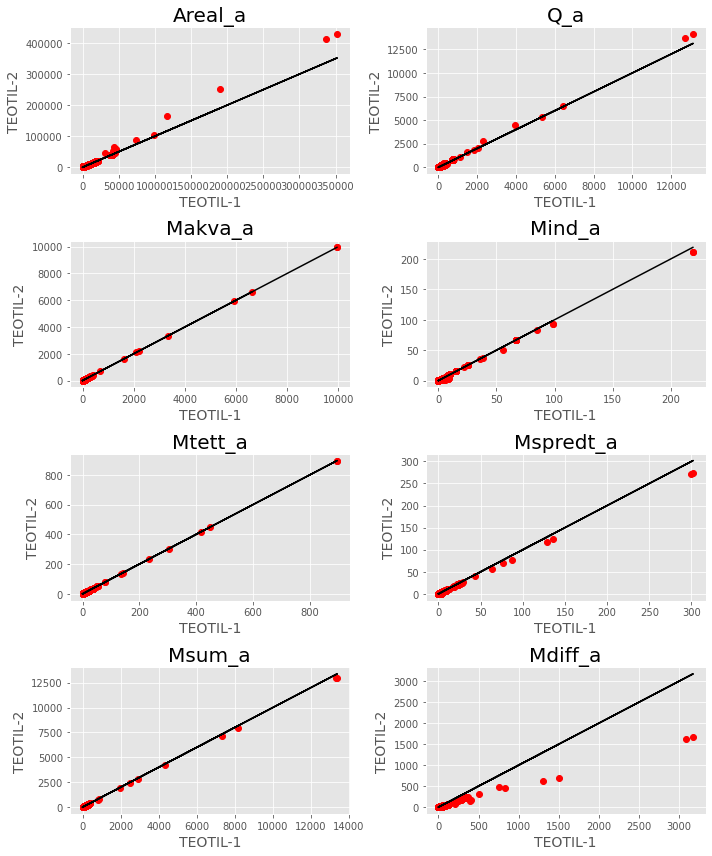

In [12]:
# Join
df = pd.merge(teo2_df, teo1_df, how="left", on="ID", suffixes=("_teotil2", "_teotil1"))

# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()

for idx, col in enumerate(t_cols[1:]):
    axes[idx].plot(df[f"{col}_teotil1"], df[f"{col}_teotil2"], "ro")
    axes[idx].plot(df[f"{col}_teotil1"], df[f"{col}_teotil1"], "k-")
    axes[idx].set_title(col, fontsize=20)
    axes[idx].set_xlabel("TEOTIL-1", fontsize=14)
    axes[idx].set_ylabel("TEOTIL-2", fontsize=14)

plt.tight_layout()

<ipython-input-13-b96fa02a073a>:3: RuntimeWarning: divide by zero encountered in log10
  df = np.log10(df)


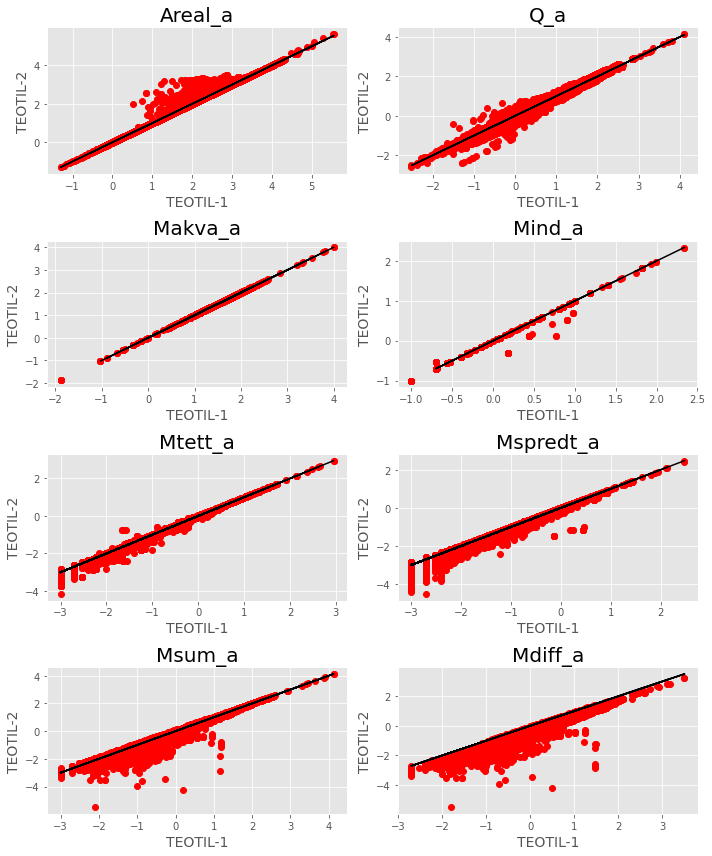

In [13]:
# Log transform
del df["ID"]
df = np.log10(df)

# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()

for idx, col in enumerate(t_cols[1:]):
    axes[idx].plot(df[f"{col}_teotil1"], df[f"{col}_teotil2"], "ro")
    axes[idx].plot(df[f"{col}_teotil1"], df[f"{col}_teotil1"], "k-")
    axes[idx].set_title(col, fontsize=20)
    axes[idx].set_xlabel("TEOTIL-1", fontsize=14)
    axes[idx].set_ylabel("TEOTIL-2", fontsize=14)

plt.tight_layout()

Overall, these results are pretty similar. The main difference is that the new model generally predicts lower overall diffuse pollution loads than TEOTIL. I haven't had chance to investigate in detail yet, but I suspect this is because the two models handle retention differently. In my model, the retention factor is applied to both local and upstream sources, whereas I think TEOTIL assumes the local inputs are added at the catchment outflow, so retention only applies to upstream component (?). More precisely, if $r_i^X$ is the retention factor for pollutant $X$ in catchment $i$, $L_i^X$ is the "internal load" of nutrient $X$ added from within catchment $i$, and $I_i^X$ is the input of nutrient $X$ received from any upstream catchments, my model assumes this:
 
$$O_i^X = (1 - r_i^X) (L_i^X + I_i^X)$$
 
whereas TEOTIL assumes this:

$$O_i^X = L_i^X + I_i^X(1 - r_i^X)$$
 
If this understanding is correct, it would explain the discrepancy quite nicely: the differences become bigger as the loads increase (i.e. moving downstream), because the differences in retention accumulate.